In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [66]:
df = pd.read_csv("lagos_air_pollution_health_data.csv - lagos_air_pollution_health_data.csv", index_col=None)

In [3]:
df.shape

(258420, 16)

In [4]:
df.head()

,C,date,pm2_5,pm10,no2,so2,o3,hospital_id,respiratory_cases,avg_age_of_patients,weather_temperature,weather_humidity,wind_speed,rainfall_mm,population_density,industrial_activity_index
0,I K E J A,1/1/2021,65.64,135.39,45.21,22.29,34.84,HOSP_IKE_1,16.0,44.0,25.1,40.0,3.1,2.2,22937.7,0.87
1,Ikeja,1/1/2021,76.49,116.65,50.01,10.20,32.19,HOSP_IKE_4,12.0,33.1,25.3,53.5,3.8,2.2,21787.8,0.32
2,I K E J A,1/1/2021,55.50,101.72,39.10,21.91,49.99,HOSP_IKE_1,20.0,33.5,27.7,72.3,4.7,1.0,14798.0,0.78
3,Ikeja,1/1/2021,56.37,138.53,46.40,28.13,24.89,HOSP_IKE_8,15.0,49.3,32.8,62.9,4.8,8.2,18013.6,0.24
4,I K E J A,1/1/2021,93.77,123.73,59.55,11.82,29.73,HOSP_IKE_3,20.0,45.4,27.9,64.8,3.4,9.1,25980.3,0.30


In [67]:
# Rename C column to city
df.rename(columns={'C': 'city'}, inplace=True)

In [6]:
print(df.dtypes)

city                          object
date                          object
pm2_5                        float64
pm10                         float64
no2                          float64
so2                          float64
o3                           float64
hospital_id                   object
respiratory_cases            float64
avg_age_of_patients          float64
weather_temperature          float64
weather_humidity             float64
wind_speed                   float64
rainfall_mm                  float64
population_density           float64
industrial_activity_index    float64
dtype: object


In [68]:
# Change data types
# Convert date column type to datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Convert city and hospital_id columns to category
df['city'] = df['city'].astype('category')
df['hospital_id'] = df['hospital_id'].astype('category')

In [69]:
# Lower column names for uniformity
df.columns = df.columns.str.lower()

In [9]:
# Check for null
df.isnull().sum()

city                         28
date                         23
pm2_5                         3
pm10                          9
no2                           1
so2                           8
o3                            7
hospital_id                   2
respiratory_cases             7
avg_age_of_patients          16
weather_temperature           4
weather_humidity              6
wind_speed                    4
rainfall_mm                   3
population_density           22
industrial_activity_index     5
dtype: int64

In [10]:
df['city'].unique()

['I K E J A', 'Ikeja', 'ikeja', NaN, 'YABA', ..., 'SURULERE', 'Surulere', 'Lekki', 'LEKKI', 'lekki']
Length: 16
Categories (15, object): ['A J A H', 'Ajah', 'I K E J A', 'Ikeja', ..., 'ikeja', 'lekki', 'surulere', 'yaba']

In [70]:
# Upper city names for uniformity and remove spaces
df['city'] = df['city'].str.replace(' ', '').str.upper()
print(df['city'].unique())

['IKEJA' nan 'YABA' 'AJAH' 'SURULERE' 'LEKKI']


### Handle Missing Values

In [71]:
# Populate empty city rows
# Define mapping of code to city name
city_mapping = {
    'AJA': 'AJAH',
    'IKE': 'IKEJA',
    'LEK': 'LEKKI',
    'SUR': 'SURULERE',
    'YAB': 'YABA',
}

# Extract city codes from hospital_id column
df['city_code'] = df['hospital_id'].str.extract(r'_([A-Z]{3})_')

# Map the extracted city codes to the full city names
df['mapped_city'] = df['city_code'].map(city_mapping)

# Fill empty cities
df['city'] = df['city'].replace('', np.nan).combine_first(df['mapped_city'])

# Drop extra columns
df.drop(columns=['city_code', 'mapped_city'], inplace=True)

df.isnull().sum()

city                          0
date                         23
pm2_5                         3
pm10                          9
no2                           1
so2                           8
o3                            7
hospital_id                   2
respiratory_cases             7
avg_age_of_patients          16
weather_temperature           4
weather_humidity              6
wind_speed                    4
rainfall_mm                   3
population_density           22
industrial_activity_index     5
dtype: int64

In [72]:
# Forward fill dates
df['date'] = df['date'].ffill()

In [73]:
# Fill numerical cols with median per hospital and date
# Drop missing hospital_ids
df = df.dropna(subset=['hospital_id'])
med_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'o3', 'respiratory_cases', 'avg_age_of_patients', 'weather_temperature', 'weather_humidity', 'wind_speed', 
            'rainfall_mm', 'population_density', 'industrial_activity_index']

for col in med_cols:
    med = df.groupby(['date', 'hospital_id'], observed=True)[col].transform('median')
    df.loc[:, col] = df[col].fillna(med)

df.isnull().sum()

city                         0
date                         0
pm2_5                        1
pm10                         0
no2                          0
so2                          0
o3                           0
hospital_id                  0
respiratory_cases            1
avg_age_of_patients          1
weather_temperature          0
weather_humidity             0
wind_speed                   0
rainfall_mm                  0
population_density           1
industrial_activity_index    0
dtype: int64

In [74]:
# Drop rows with missing entries
df = df.dropna(subset=['pm2_5', 'respiratory_cases', 'avg_age_of_patients', 'population_density'])
df.head()

,city,date,pm2_5,pm10,no2,so2,o3,hospital_id,respiratory_cases,avg_age_of_patients,weather_temperature,weather_humidity,wind_speed,rainfall_mm,population_density,industrial_activity_index
0,IKEJA,2021-01-01,65.64,135.39,45.21,22.29,34.84,HOSP_IKE_1,16.0,44.0,25.1,40.0,3.1,2.2,22937.7,0.87
1,IKEJA,2021-01-01,76.49,116.65,50.01,10.20,32.19,HOSP_IKE_4,12.0,33.1,25.3,53.5,3.8,2.2,21787.8,0.32
2,IKEJA,2021-01-01,55.50,101.72,39.10,21.91,49.99,HOSP_IKE_1,20.0,33.5,27.7,72.3,4.7,1.0,14798.0,0.78
3,IKEJA,2021-01-01,56.37,138.53,46.40,28.13,24.89,HOSP_IKE_8,15.0,49.3,32.8,62.9,4.8,8.2,18013.6,0.24
4,IKEJA,2021-01-01,93.77,123.73,59.55,11.82,29.73,HOSP_IKE_3,20.0,45.4,27.9,64.8,3.4,9.1,25980.3,0.30


#### Aggregate the data my date

In [75]:
daily_agg = df.groupby(['date', 'hospital_id', 'city'], observed='True').agg({
    'pm2_5': 'mean',
    'pm10': 'mean',
    'no2': 'mean',
    'so2': 'mean',
    'o3': 'mean',
    'respiratory_cases': 'sum',
    'avg_age_of_patients': 'mean',
    'weather_temperature': 'mean',
    'weather_humidity': 'mean',
    'wind_speed': 'mean',
    'rainfall_mm': 'sum',
    'population_density': 'mean',
    'industrial_activity_index': 'mean'
}).reset_index()

In [76]:
rounding_rules = {
    'pm2_5': 2,
    'pm10': 2,
    'no2': 2,
    'so2': 2,
    'o3': 2,
    'respiratory_cases': 0,
    'avg_age_of_patients': 0,
    'weather_temperature': 2,
    'weather_humidity': 2,
    'wind_speed': 2,
    'rainfall_mm': 2,
    'population_density': 2,
    'industrial_activity_index': 2,
}

# Apply the rounding rules to the DataFrame
daily_agg = daily_agg.round(rounding_rules)

In [77]:
daily_agg['month'] = daily_agg['date'].dt.month_name()
daily_agg['year'] = daily_agg['date'].dt.year

In [78]:
# Highlight harmattan seasons
def is_harmattan(month):
    if month in ['January', 'February', 'December']:
        return 'Harmattan'
    else:
        return 'Rainy'

daily_agg['season'] = daily_agg['month'].apply(is_harmattan)

In [22]:
daily_agg.head()

,date,hospital_id,city,pm2_5,pm10,no2,so2,o3,respiratory_cases,avg_age_of_patients,weather_temperature,weather_humidity,wind_speed,rainfall_mm,population_density,industrial_activity_index,month,year,season
0,2021-01-01,HOSP_AJA_1,AJAH,51.51,110.95,33.05,29.88,33.40,13.0,43.0,29.40,56.30,1.50,9.6,11331.40,0.39,January,2021,Harmattan
1,2021-01-01,HOSP_AJA_10,AJAH,68.24,99.33,49.67,21.39,42.42,56.0,34.0,28.56,55.24,2.10,32.0,18440.52,0.47,January,2021,Harmattan
2,2021-01-01,HOSP_AJA_2,AJAH,67.46,109.87,54.26,17.86,35.20,49.0,30.0,33.10,46.57,1.63,20.6,18404.80,0.47,January,2021,Harmattan
3,2021-01-01,HOSP_AJA_3,AJAH,70.45,116.58,43.06,13.55,36.08,39.0,38.0,33.37,58.50,2.97,20.0,23579.73,0.73,January,2021,Harmattan
4,2021-01-01,HOSP_AJA_4,AJAH,66.44,104.02,51.59,13.34,45.08,57.0,38.0,31.30,49.87,1.97,4.9,15605.33,0.38,January,2021,Harmattan


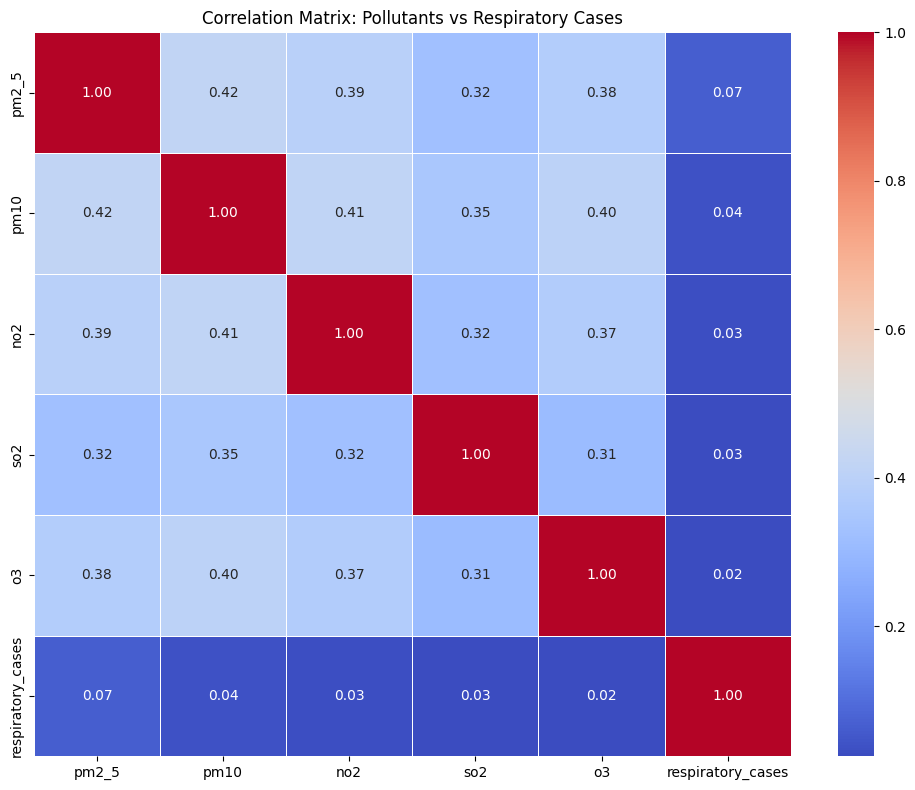

In [79]:
# Create pollution_index
# Use correlation between the pollutants and the respiratory cases
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'o3']
correlation_cols = ['pm2_5', 'pm10', 'no2', 'so2', 'o3', 'respiratory_cases']
correlation_matrix = daily_agg[correlation_cols].corr()
pollution_weights = {}

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix: Pollutants vs Respiratory Cases')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

total_corr = 0
for pollutant in pollutants:
    corr, p_value = pearsonr(daily_agg[pollutant], daily_agg['respiratory_cases'])
    total_corr = total_corr + abs(corr)

# Calculate the weights
for pollutant in pollutants:
    corr, p_value = pearsonr(daily_agg[pollutant], daily_agg['respiratory_cases'])
    pollution_weights[pollutant] = round(abs(corr) / total_corr, 2)  # Normalize by total absolute correlation


# Normalize pollutants using Min-Max scaling
for pollutant in pollutants:
    min_val = daily_agg[pollutant].min()
    max_val = daily_agg[pollutant].max()
    daily_agg[f'{pollutant}_norm'] = (daily_agg[pollutant] - min_val) / (max_val - min_val)

# Calculate average using weighted averages
daily_agg['pollution_index'] = (
    daily_agg['pm2_5_norm'] * pollution_weights['pm2_5'] +
    daily_agg['pm10_norm'] * pollution_weights['pm10'] +
    daily_agg['no2_norm'] * pollution_weights['no2'] +
    daily_agg['o3_norm'] * pollution_weights['o3'] +
    daily_agg['so2_norm'] * pollution_weights['so2']
) * 100

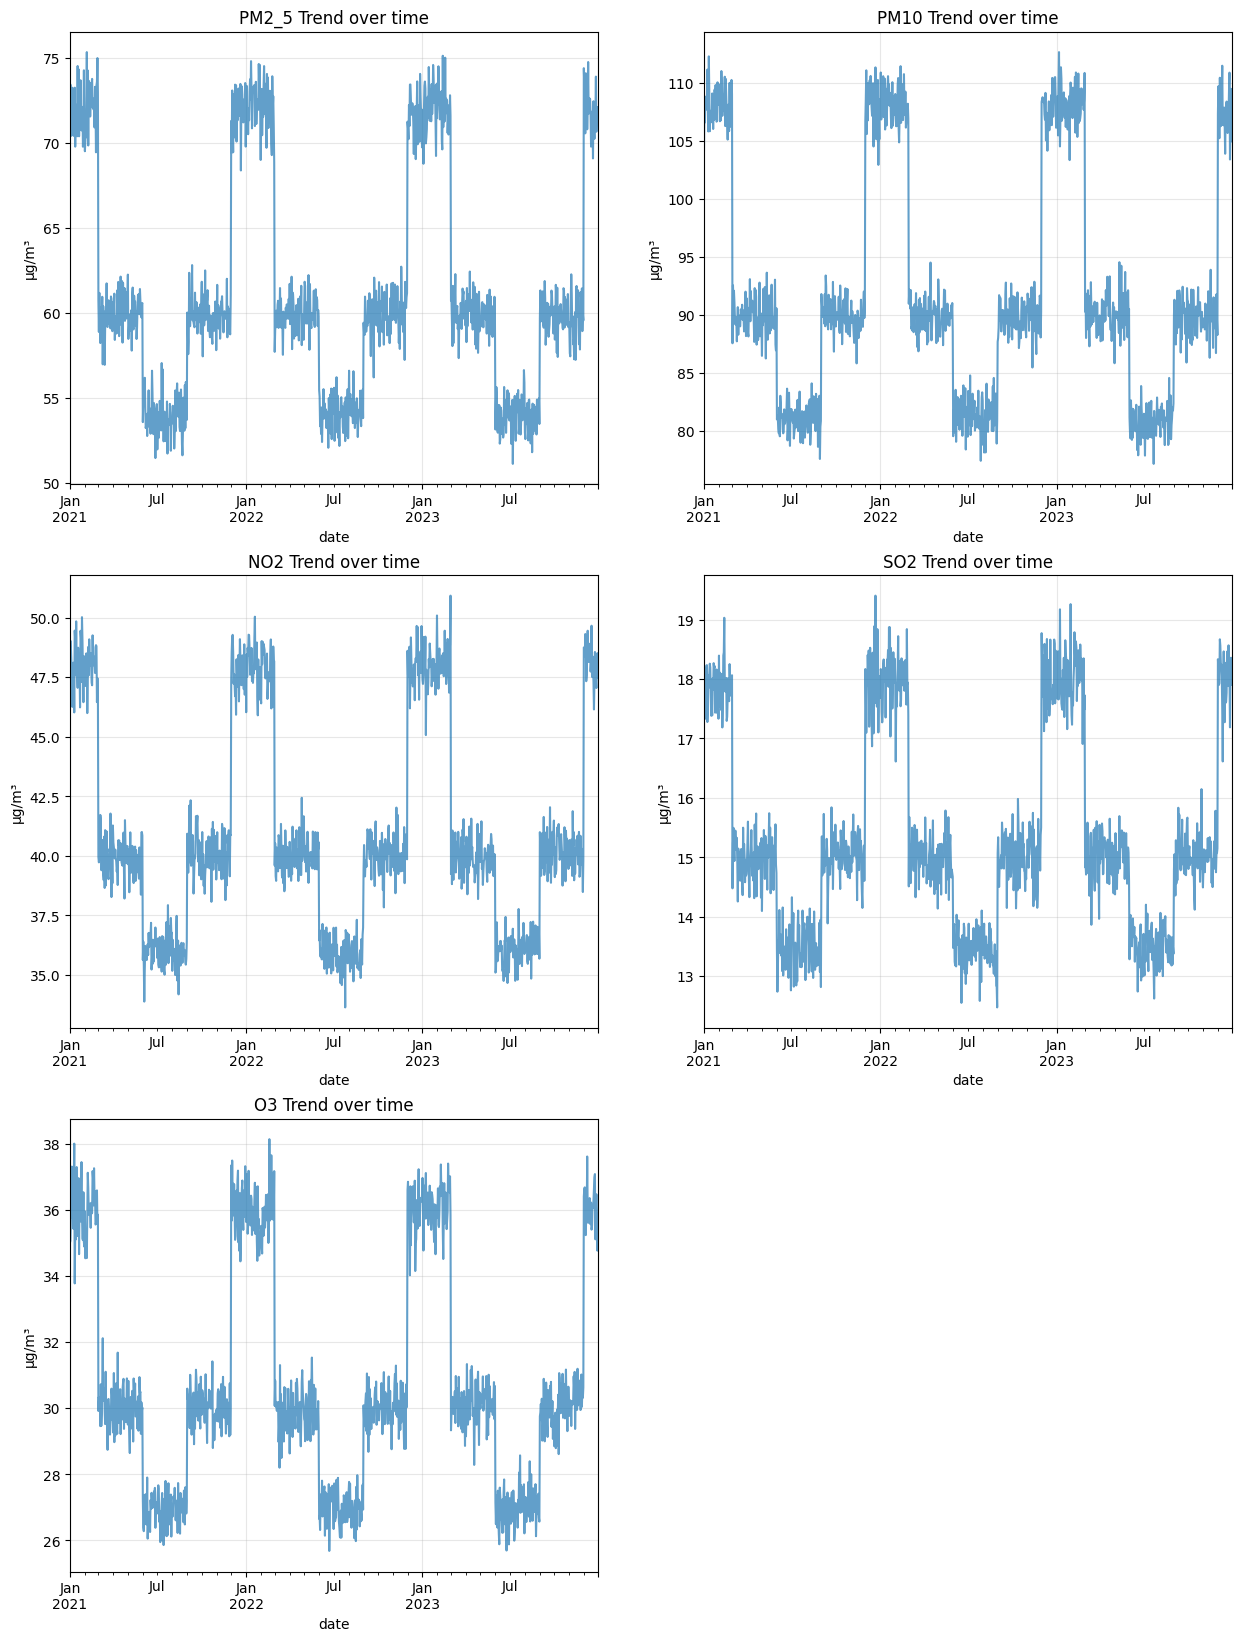

In [80]:
# Pollutant trends
pollutants = ['pm2_5', 'pm10', 'no2', 'so2', 'o3']
plt.figure(figsize=(15, 20))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(3, 2, i)
    daily_agg.groupby('date')[pollutant].mean().plot(alpha=0.7)
    plt.title(f'{pollutant.upper()} Trend over time')
    plt.ylabel('μg/m³')
    plt.grid(True, alpha=0.3)

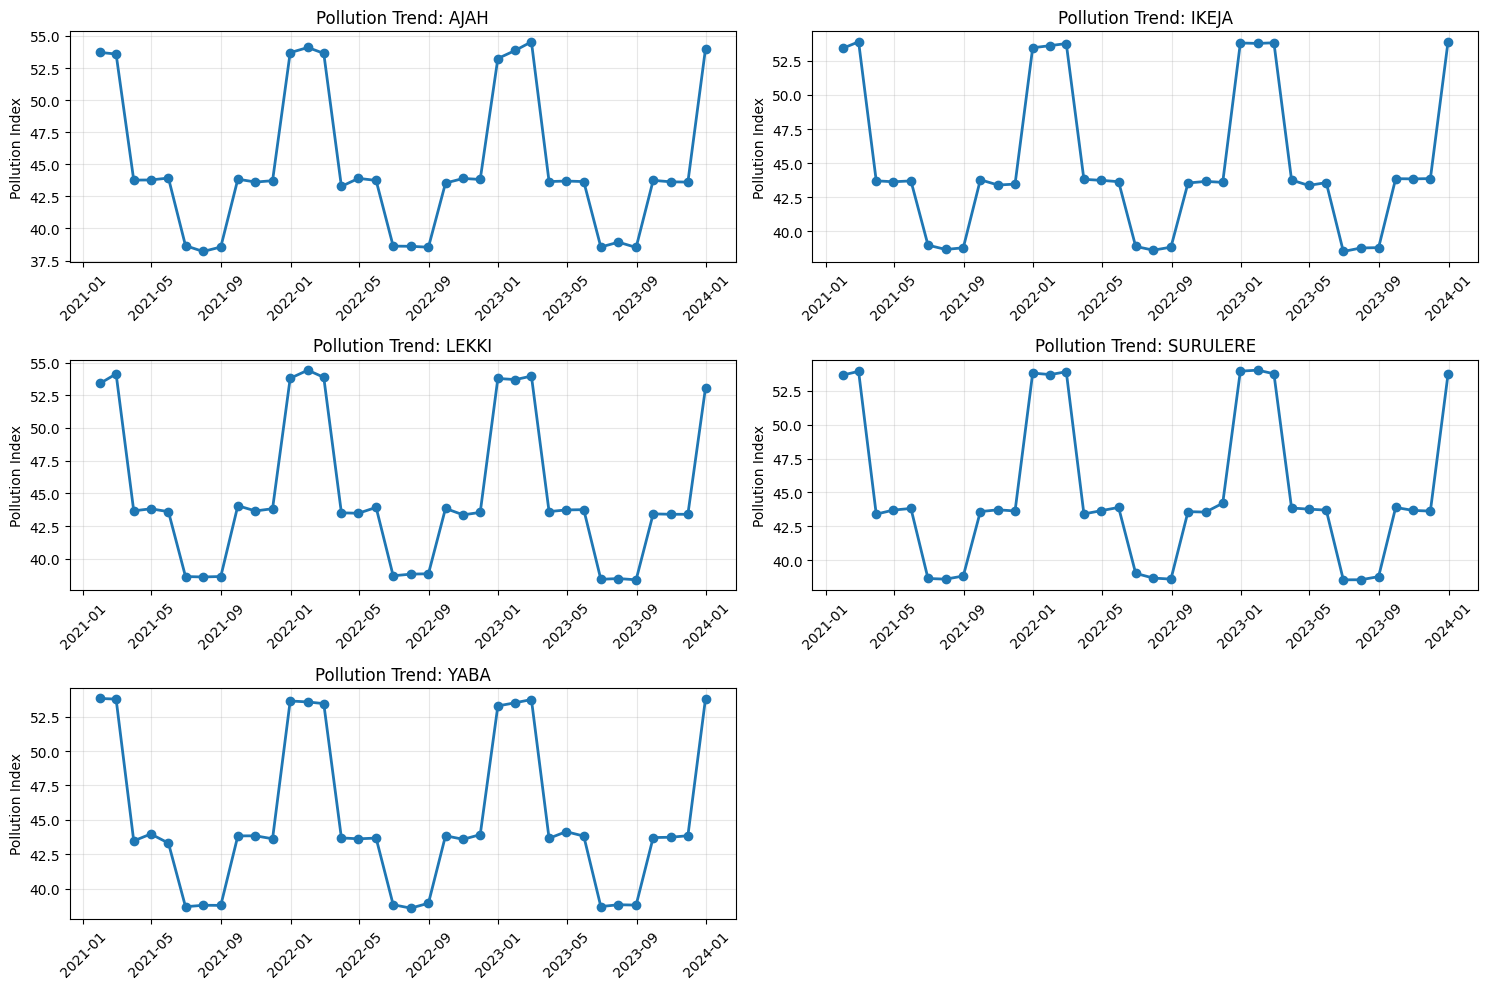

In [81]:
# Time series trends by city
plt.figure(figsize=(15, 10))
for i, city in enumerate(daily_agg['city'].unique(), 1):
    city_data = daily_agg[daily_agg['city'] == city]
    monthly_data = city_data.groupby(pd.Grouper(key='date', freq='ME'))['pollution_index'].mean()
    
    plt.subplot(3, 2, i)
    plt.plot(monthly_data.index, monthly_data.values, marker='o', linewidth=2)
    plt.title(f'Pollution Trend: {city}')
    plt.ylabel('Pollution Index')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

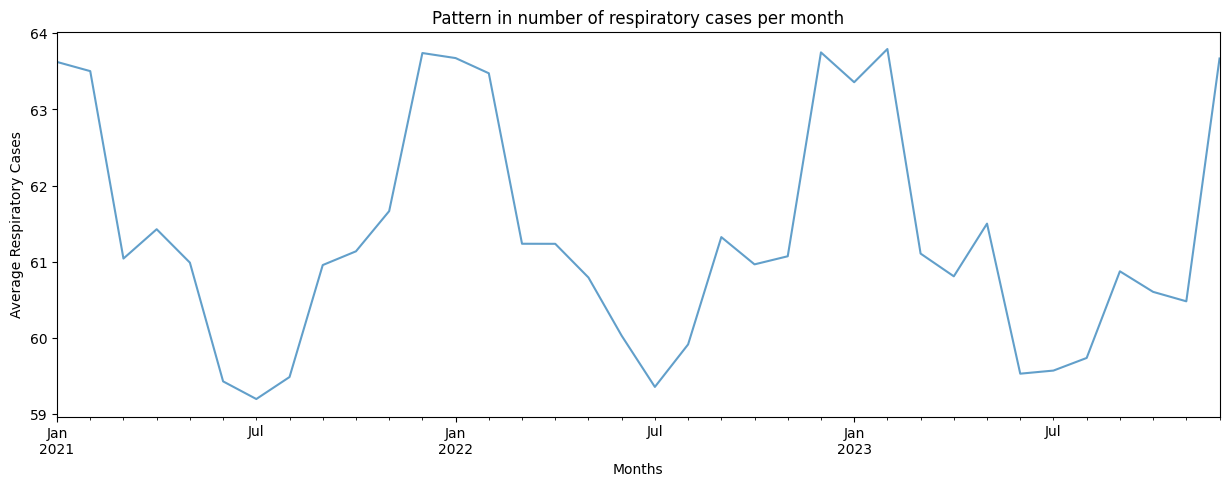

In [82]:
plt.figure(figsize=(15, 5))
daily_agg.groupby(pd.Grouper(key='date', freq='ME'))['respiratory_cases'].mean().plot(alpha=0.7)
plt.title('Pattern in number of respiratory cases per month')
plt.ylabel('Average Respiratory Cases')
plt.xlabel('Months')
plt.show()

#### Machine Learning

In [34]:
daily_agg.to_csv('air_pollution_daily_agg.csv')

In [90]:
# Prepare the data for modelling
# season_dummies = pd.get_dummies(daily_agg['season'], prefix='season')
# daily_agg = pd.concat([daily_agg, season_dummies], axis=1)
# features = ['pm2_5', 'pm10', 'no2', 'so2', 'o3', 'weather_temperature', 
#            'weather_humidity', 'wind_speed', 'rainfall_mm', 
#            'industrial_activity_index', 'season_Harmattan', 'season_Rainy']

# X = daily_agg[features]
# y = daily_agg.loc[X.index, 'respiratory_cases']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Scale and Train
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
linear_y_pred = linear_model.predict(X_test_scaled)
linear_mae = mean_absolute_error(y_test, linear_y_pred)
print(linear_mae)

# Random Forest
random_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
random_model.fit(X_train_scaled, y_train)
random_y_pred = random_model.predict(X_test_scaled)
random_mae = mean_absolute_error(y_test, random_y_pred)
print(random_mae)

# Calculate feature importance in Random Forest
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': random_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop Predictive Features (Random Forest):")
for i, row in feature_importance.iterrows():
    print(f"  {row['feature']:25}: {row['importance']:.4f}")

13.354951291111425
12.763959320657374

Top Predictive Features (Random Forest):
  rainfall_mm              : 0.9167
  pm2_5                    : 0.0161
  weather_humidity         : 0.0126
  wind_speed               : 0.0115
  weather_temperature      : 0.0094
  industrial_activity_index: 0.0092
  pm10                     : 0.0066
  so2                      : 0.0064
  o3                       : 0.0060
  no2                      : 0.0055
  season_Rainy             : 0.0001
  season_Harmattan         : 0.0000
